# Hotdog/**!**Hotdog image classifier using Keras and TensorFlow

## Introduction

""What would you say if I told you there is a app on the market that tell you if you have a hotdog or not a hotdog?" Jian-Yang, [Silicon Valley, season 4 episode 4](https://www.youtube.com/watch?v=pqTntG1RXSY). This question is one of the best known in the artificial intelligence industry, being introduced by a TV series extremely known and appreciated by technology lovers, namely Silicon Valley.

Even if it sounds trivial, this question hides behind it basic and extremely important notions of artificial intelligence, with focus on the problem of classification. The process that ultimately determines the recognition of photos that contain a hotdog, compared to any other photo (not hotdog), can then be extrapolated and customized to classify a large number of objects. In the following, I will describe in detail the stages of creating a neural model specialized in classifying images into these two categories.

The objective of this project is simple. Given an image, does it contain a hotdog or not? :)

### Imports 

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os

from skimage import exposure
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from google.colab.patches import cv2_imshow
from skimage import color
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D, \
    BatchNormalization, Flatten
from sklearn.metrics import confusion_matrix

#### Connect to google drive account

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### Constants

In [3]:
dataset_path = "/content/drive/My Drive/Colab Notebooks/datasets/food-101/"
dataset_path_images = "/content/drive/My Drive/Colab Notebooks/datasets/food-101/images/"
dataset_models = "/content/drive/My Drive/Colab Notebooks/datasets/food-101/models/"

!ls "/content/drive/My Drive/Colab Notebooks/datasets/food-101/images/"

apple_pie	    eggs_benedict	     onion_rings
baby_back_ribs	    escargots		     oysters
baklava		    falafel		     pad_thai
beef_carpaccio	    filet_mignon	     paella
beef_tartare	    fish_and_chips	     pancakes
beet_salad	    foie_gras		     panna_cotta
beignets	    french_fries	     peking_duck
bibimbap	    french_onion_soup	     pho
bread_pudding	    french_toast	     pizza
breakfast_burrito   fried_calamari	     pork_chop
bruschetta	    fried_rice		     poutine
caesar_salad	    frozen_yogurt	     prime_rib
cannoli		    garlic_bread	     pulled_pork_sandwich
caprese_salad	    gnocchi		     ramen
carrot_cake	    greek_salad		     ravioli
ceviche		    grilled_cheese_sandwich  red_velvet_cake
cheesecake	    grilled_salmon	     risotto
cheese_plate	    guacamole		     samosa
chicken_curry	    gyoza		     sashimi
chicken_quesadilla  hamburger		     scallops
chicken_wings	    hot_and_sour_soup	     seaweed_salad
chocolate_cake	    hot_dog		     shrimp_and_grits
chocolate_mousse    huevo

## Dataset

The first step, and probably most important, is to obtain and process an appropriate dataset. I say about this step that it is the most important because a neural network can be as good as the dataset that learned it. The dataset is the foundation of a correct recognition algorithm (regardless of the domain). 

In this sense, we can say that there are not too many difficulties. The field of image classification that represents food types is already vast and frequently exploited, therefore finding a dataset for conducting experiments has not been difficult. Thus, a dataset available online was used, which contains images with 101 types of food, each type having 1000 images available. It can be found here: https://www.kaggle.com/dansbecker/food-101


In [4]:
def load_and_process_image(filepath, image_size):
    print(filepath)
    '''
    Load image using a filepath, and then process it as follows:
         - resize
         - normalize

    @param: filepath: location of an image
    @param: image_size: tuple object; eq: (32, 32)
    '''
    image = cv2.imread(filepath)
    try:
      image = cv2.resize(image, image_size)
    except:
      print("An exception occurred")

    return image

def load_images(image_paths, class_label, image_size):
    '''
    Go through each path corresponding to the images, 
    save the uploaded image and its class label
    '''
    x = []
    y = []
    
    for path in image_paths:
        image = load_and_process_image(path, image_size)        
        x.append(image)
        y.append(class_label)
        
    # Data augmentation
    
    return x, y

def convert_to_grayscale(images):
    '''
    Convert RGB image to grayscale
    Check: https://www.mathworks.com/help/matlab/ref/rgb2gray.html
    Formula: 0.2989 * R + 0.5870 * G + 0.1140 * B 
    '''    
    images = 0.2989*images[:,:,:,0] + 0.5870*images[:,:,:,1] + 0.1140*images[:,:,:,2]
    return images

def preprocess_data(images):
    '''
    Processes the initial data set, using various auxiliary methods
    '''
    grayImages = convert_to_grayscale(images)

    grayImages = (grayImages / 255.).astype(np.float32)
    for i in range(images.shape[0]):
        grayImages[i] = exposure.equalize_hist(grayImages[i])

    # Reshape array to a specific input shape
    grayImages = grayImages.reshape(grayImages.shape + (1,)) 
    return grayImages

In [5]:
def load_dataset(image_size, hotdogs, not_hotdogs):
    '''
    Load the dataset and separate the images 
    (hotdog/not-hotdog) and the corresponding class labels (0/1)
    '''
    image_size = (image_size, image_size)
    x_hotdog, y_hotdog = load_images(hotdogs, 0, image_size)
    x_not_hotdog, y_not_hotdog = load_images(not_hotdogs, 1, image_size)

    print("There are", len(x_hotdog), "hotdog images")
    print("There are", len(x_not_hotdog), "not hotdog images")
    
    # Convert X, Y to numpy array
    X = np.array(x_hotdog + x_not_hotdog)
    Y = np.array(y_hotdog + y_not_hotdog)
    
    return X, Y

### Start point ("main module")

Hotdog images 50
Not hotdog images 500
Hotdog


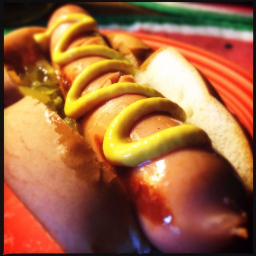

Not Hotdog


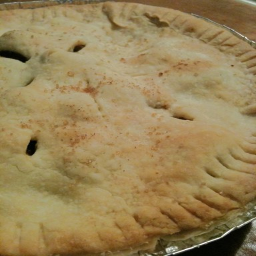

/content/drive/My Drive/Colab Notebooks/datasets/food-101/images/hot_dog/5079.jpg
/content/drive/My Drive/Colab Notebooks/datasets/food-101/images/hot_dog/51643.jpg
/content/drive/My Drive/Colab Notebooks/datasets/food-101/images/hot_dog/41227.jpg
/content/drive/My Drive/Colab Notebooks/datasets/food-101/images/hot_dog/41226.jpg
/content/drive/My Drive/Colab Notebooks/datasets/food-101/images/hot_dog/92613.jpg
/content/drive/My Drive/Colab Notebooks/datasets/food-101/images/hot_dog/2741948.jpg
/content/drive/My Drive/Colab Notebooks/datasets/food-101/images/hot_dog/884796.jpg
/content/drive/My Drive/Colab Notebooks/datasets/food-101/images/hot_dog/120471.jpg
/content/drive/My Drive/Colab Notebooks/datasets/food-101/images/hot_dog/1913270.jpg
/content/drive/My Drive/Colab Notebooks/datasets/food-101/images/hot_dog/599728.jpg
/content/drive/My Drive/Colab Notebooks/datasets/food-101/images/hot_dog/3764724.jpg
/content/drive/My Drive/Colab Notebooks/datasets/food-101/images/hot_dog/189203

In [9]:
hotdogs = []
not_hotdogs = []

for food_category in os.listdir(dataset_path_images):
  if food_category == "hot_dog":
     # Hotdog - class 0
     for hotdog_img in os.listdir(dataset_path_images + "hot_dog/"):
       if len(hotdogs) >= 50:
          break;
       hotdogs.append(dataset_path_images + "hot_dog/" + hotdog_img)
  else:
     # not-Hotdog - class 1
     k = 0
     for not_hotdog_img in os.listdir(dataset_path_images + food_category):
       if k >= 5:
          break;
       not_hotdogs.append(dataset_path_images + food_category + "/" + not_hotdog_img)
       k = k + 1

print("Hotdog images", len(hotdogs))
print("Not hotdog images", len(not_hotdogs))

# Print two images using cv2_imshow
# Check: https://www.geeksforgeeks.org/python-opencv-cv2-imshow-method/
print("Hotdog")
hotdog_image = cv2.imread(hotdogs[10])
hotdog_image = cv2.resize(hotdog_image, (256, 256))
cv2.normalize(hotdog_image, hotdog_image, 0, 255, cv2.NORM_MINMAX)
cv2_imshow(hotdog_image)

print("Not Hotdog")
not_hotdog_image = cv2.imread(not_hotdogs[30])
not_hotdog_image = cv2.resize(not_hotdog_image, (256, 256))
cv2.normalize(not_hotdog_image, not_hotdog_image, 0, 255, cv2.NORM_MINMAX)
cv2_imshow(not_hotdog_image)

# All the images will be resized! Set a specific image size
# This value will influence the training process
image_size = 64

X_images, Y_labels = load_dataset(image_size, hotdogs, not_hotdogs)
X_images = preprocess_data(X_images)
print(X_images.shape)
print(Y_labels.shape)
Y_labels = to_categorical(Y_labels)

# Define a random state value
# If you set random_state = 42 then no matter how many times you execute 
# your code, the result would be the same 
# (same values in train and test datasets)
rand_state = 42
tf.random.set_seed(rand_state)
np.random.seed(rand_state)

# Split X_images into X_train and X_test and Y_labes into Y_train and Y_test
X_train, X_test, Y_train, Y_test = train_test_split(X_images, Y_labels, 
                                                    test_size=0.20,
                                                    random_state=rand_state)

# print(X_train[1])
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

input_shape = (image_size, image_size, 1) 

## Build the model

TensorFlow & Keras

- Basic classification (tensorflow tutorial): https://www.tensorflow.org/tutorials/keras/classification


In [ ]:
# We will define an interface that will expose the 
# main methods that the process of training/testing 
# a convolutional neural network must contain
class CNNInterface:
    def train(self, X_train, Y_train, X_test, Y_test):
        pass

    def evaluate(self, X_train, Y_train, X_test, Y_test):
        pass

    def save_model(self):
        pass

    def confusion_matrix(self, X_test, Y_test_values):
        pass


In [ ]:
class MainCNNRecognition(CNNInterface):
    def __init__(self, name, input_shape):
          self.__input_shape = input_shape
          self.__name = name
          self.__score_train = []
          self.__score_test = []
          self.__history = None

          print("Initializing CNN")
          self.__model = Sequential()

          self.__model = Sequential()
          self.__model.add(Conv2D(32, kernel_size=(3, 3),
                          activation='relu',
                          input_shape=input_shape))
          self.__model.add(MaxPooling2D((2, 2)))
          self.__model.add(Dropout(0.2))

          self.__model.add(Conv2D(64, (3, 3), activation='relu'))
          self.__model.add(MaxPooling2D(pool_size=(2, 2)))
          self.__model.add(Dropout(0.2))

          self.__model.add(Conv2D(128, (3, 3), activation='relu'))
          self.__model.add(Dropout(0.2))

          self.__model.add(Flatten())
          self.__model.add(Dense(128, activation='relu'))
          self.__model.add(Dropout(0.2))
          self.__model.add(Dense(2, activation='softmax'))

          print("CNN Initialized")

    def __str__(self):
        return str(self.__model.summary())

    def train(self, X_train, Y_train, X_test, Y_test):
        print("Start training model")

        self.__model.compile(loss="binary_crossentropy",
                            optimizer="adam",
                            metrics=['accuracy'])

        self.__history = self.__model.fit(X_train, Y_train,
                                  batch_size=64,
                                  epochs=50, 
                                  validation_data=(X_test, Y_test))

        print("Training completed")

    def evaluate(self, X_train, Y_train, X_test, Y_test):
        self.__score_train = self.__model.evaluate(
            x=X_train,
            y=Y_train)

        self.__score_test = self.__model.evaluate(
            x=X_test,
            y=Y_test)

        print("Train loss", self.__score_train[0])
        print("Train accuracy", self.__score_train[1])

        print("Test loss", self.__score_test[0])
        print("Test accuracy", self.__score_test[1])

        return [self.__score_train, self.__score_test]

    def save_model(self):
        model_path = dataset_models + self.__name + ".h5"
        self.__model.save(model_path)

    def confusion_matrix(self, X_test, Y_test_values):
        y_pred = self.__model.predict_classes(X_test)
        Y_test_values = np.argmax(Y_test_values, axis=1)
        conf_matrix = confusion_matrix(Y_test_values, y_pred)
        print(conf_matrix)

    def plot_history(self):
        if self.__history is not None:
            # Summarize history for accuracy
            plt.plot(self.__history.history['accuracy'])
            plt.plot(self.__history.history['val_accuracy'])
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()

            # Summarize history for loss
            plt.plot(self.__history.history['loss'])
            plt.plot(self.__history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()


In [ ]:
cnnRecognition = MainCNNRecognition("cnn_hotdog_v5_small", input_shape)
cnnRecognition.train(X_train, Y_train, X_test, Y_test)
cnnRecognition.evaluate(X_train, Y_train, X_test, Y_test)
cnnRecognition.save_model()
cnnRecognition.confusion_matrix(X_test, Y_test)
cnnRecognition.plot_history()

Initializing CNN
CNN Initialized
Start training model
Epoch 1/50
14/14 [==============================] - 6s 460ms/step - loss: 0.4245 - accuracy: 0.9114 - val_loss: 0.3526 - val_accuracy: 0.8909
Epoch 2/50
14/14 [==============================] - 6s 445ms/step - loss: 0.3001 - accuracy: 0.9136 - val_loss: 0.3517 - val_accuracy: 0.8909
Epoch 3/50
14/14 [==============================] - 6s 448ms/step - loss: 0.2919 - accuracy: 0.9136 - val_loss: 0.3501 - val_accuracy: 0.8909
Epoch 4/50
14/14 [==============================] - 6s 446ms/step - loss: 0.3108 - accuracy: 0.9136 - val_loss: 0.3715 - val_accuracy: 0.8909
Epoch 5/50
14/14 [==============================] - 6s 434ms/step - loss: 0.3116 - accuracy: 0.9136 - val_loss: 0.3515 - val_accuracy: 0.8909
Epoch 6/50
14/14 [==============================] - 6s 447ms/step - loss: 0.2986 - accuracy: 0.9136 - val_loss: 0.3501 - val_accuracy: 0.8909
Epoch 7/50
14/14 [==============================] - 6s 449ms/step - loss: 0.2935 - accuracy: 0

KeyboardInterrupt: ignored

## References

- Articles
  - https://www.kaggle.com/mjmurphy28/cnn-with-keras-accuracy-98
  - https://towardsdatascience.com/building-the-hotdog-not-hotdog-classifier-from-hbos-silicon-valley-c0cb2317711f
  - https://medium.com/@timanglade/how-hbos-silicon-valley-built-not-hotdog-with-mobile-tensorflow-keras-react-native-ef03260747f3#61c5
  - https://becominghuman.ai/not-hotdog-with-keras-and-tensorflow-js-fab138fe7e84
  - https://www.kaggle.com/bugraokcu/cnn-with-keras
- Dataset
  - https://www.kaggle.com/dansbecker/food-101